In [15]:
compounds_str = """
part1-CO2_50-FeO_50:
CO2: 50%
FeO: 50%

part2-CO_20-Fe_50-AgO_20-AlO_10:
CO: 20%
Fe: 50%
AgO: 20%
AlO: 10%

part3-HCO2_15-FeO2_60-Ag_25:
HCO2: 15%
FeO2: 60%
Ag: 25%

part4-HCO2_20-FeO2_60-Ag_20:
HCO2: 20%
FeO2: 60%
Ag: 20%
"""
import torch
import datetime
from typing import List

from mark_essential_oils import Config, gen_examples, train

import matplotlib.pyplot as plt
from IPython import display

# import seaborn as sns
# import pandas
# sns.set_theme()


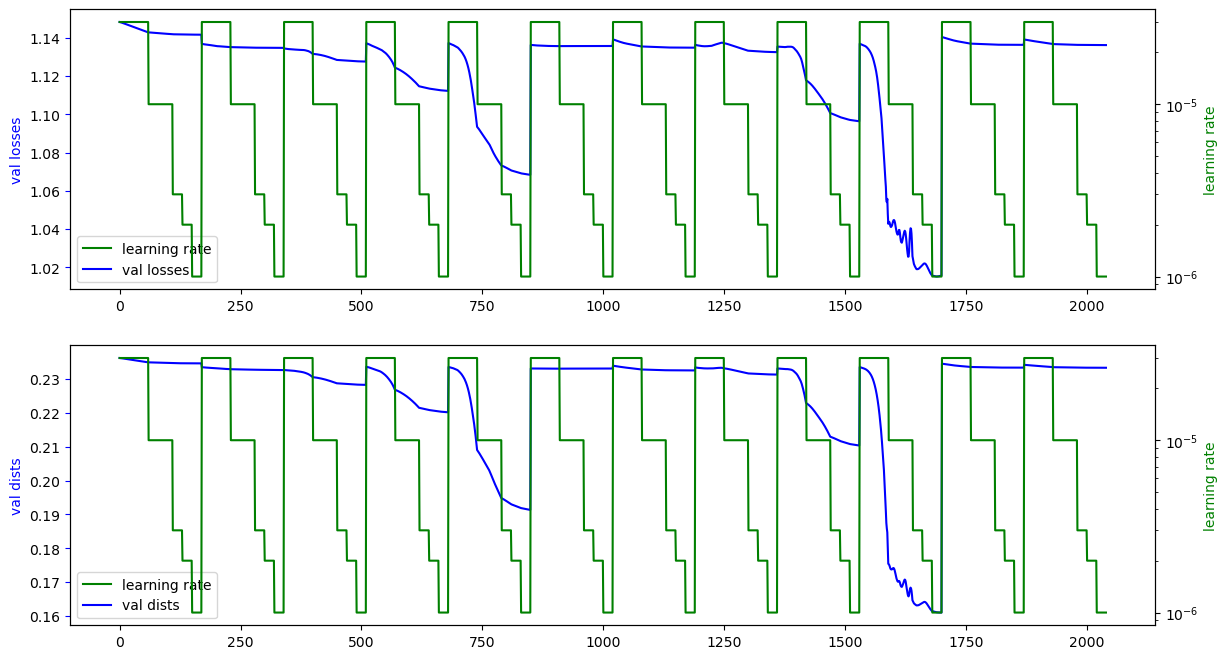

saved outputs/mark_essential_oils2/results-20230216-120934-epoch_170-num_hidden_06-hidden_size_18-lr_1.000000E-06.png

num_hidden 6, hidden_size 36
lr = 3e-05 (num_hidden 6, hidden_size 36)


KeyboardInterrupt: 

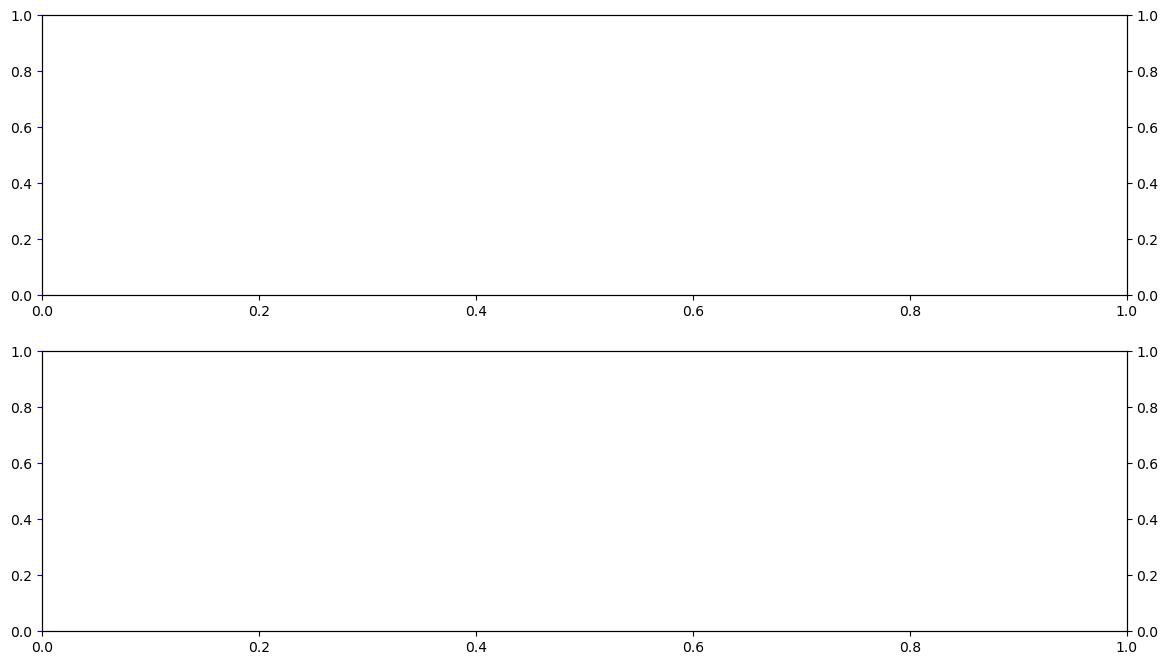

In [34]:
%matplotlib inline
cfg = Config(compounds_str)
cfg.setup(num_hidden=3, hidden_size=len(cfg.all_mol_names), lr=1e-4)

train_losses = list()
val_losses = list()
val_diffs = list()
val_dists = list()
learning_rates = list()

color_val = "blue"
color_lr = "green"
fig = plt.gcf()

def reset_plot():
    plt.rcParams["figure.figsize"] = (14, 8) # (w, h)
    fig.clear()
    ax_val_losses = fig.add_subplot(2, 1, 1, label="val losses")
    ax_val_dists = fig.add_subplot(2, 1, 2, label="val dists")

    all_axes = [ax_val_losses, ax_val_dists]
    all_axes_lr = [ax.twinx() for ax in all_axes]

    for ax in all_axes_lr:
        ax.set_yscale("log")
        ax.set_label("learning rate")
        ax.set_ylabel(ax.get_label(), color=color_lr)

    for ax in all_axes:
        ax.set_ylabel(ax.get_label(), color=color_val)
        ax.tick_params('y', color=color_val)

    return all_axes, all_axes_lr

num_mol = len(cfg.all_mol_names)
hp_num_batches = 10
hp_batch_size = 1000
hp_learning_rates = {3e-5: 6000, 1e-5: 5000, 3e-6: 2000, 2e-6: 2000, 1e-6: 2000}
hp_num_hidden = [4, 5, 6]
hp_hidden_size = [num_mol, num_mol * 2, num_mol * 4, num_mol * 6, num_mol * 8]

# TODO - only for fast debugging
# hp_learning_rates = {k: v//100 for k, v in hp_learning_rates.items()}

data_train = gen_examples(cfg, hp_num_batches, hp_batch_size)
data_val = gen_examples(cfg, hp_num_batches, hp_batch_size)

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filename_base = ["outputs", "mark_essential_oils2", "results-" + timestr]
filename_base = "/".join(filename_base)

for num_hidden in hp_num_hidden:
    for hidden_size in hp_hidden_size:
        cfg.setup(num_hidden=num_hidden, hidden_size=hidden_size, lr=1e-4)

        print()
        print(f"num_hidden {num_hidden}, hidden_size {hidden_size}")
        total_epochs = 0
        for lr, epochs in hp_learning_rates.items():
            print(f"lr = {lr} (num_hidden {num_hidden}, hidden_size {hidden_size})")
            cfg.optim = torch.optim.AdamW(cfg.net.parameters(), lr=lr)

            tlosses, vlosses, vdists = train(cfg, epochs, data_train, data_val)

            train_losses.extend(tlosses)
            val_losses.extend(vlosses)
            val_dists.extend(vdists)
            learning_rates.extend([lr] * epochs)

            all_axes, all_axes_lr = reset_plot()
            all_vals = [val_losses, val_dists]
            for axes, axes_lr, vals in zip(all_axes, all_axes_lr, all_vals):
                axes.plot(vals, color=color_val, label=axes.get_label())
                lines, labels = axes.get_legend_handles_labels()

                axes_lr.plot(learning_rates, color=color_lr, label=axes_lr.get_label())
                lines_lr, labels_lr = axes_lr.get_legend_handles_labels()

                axes.legend(lines_lr + lines, labels_lr + labels, loc=0)
                
            display.clear_output(True)
            display.display(fig)

            total_epochs += epochs

            filename = f"{filename_base}-epoch_{total_epochs}-num_hidden_{num_hidden:02}-hidden_size_{hidden_size:02}-lr_{lr:5E}.png"
            fig.savefig(filename)
            print(f"saved {filename}")

            for ax in [*all_axes, *all_axes_lr]:
                ax.clear()


In [ ]:
cfg.optim = torch.optim.AdamW(cfg.net.parameters(), lr=1e-6)
tlosses, vlosses = train(cfg, epochs, data_train, data_val)


epoch 240/5000: train loss 0.03431, val loss 0.03375
epoch 482/5000: train loss 0.03423, val loss 0.03365
epoch 723/5000: train loss 0.03425, val loss 0.03375
epoch 964/5000: train loss 0.03422, val loss 0.03373
epoch 1203/5000: train loss 0.03417, val loss 0.03368
epoch 1444/5000: train loss 0.03412, val loss 0.03364
epoch 1683/5000: train loss 0.03413, val loss 0.03358
epoch 1926/5000: train loss 0.03411, val loss 0.03361
epoch 2167/5000: train loss 0.03411, val loss 0.03365
epoch 2407/5000: train loss 0.03408, val loss 0.03352
epoch 2648/5000: train loss 0.03409, val loss 0.03356
epoch 2889/5000: train loss 0.03396, val loss 0.03350
epoch 3130/5000: train loss 0.03398, val loss 0.03341
epoch 3372/5000: train loss 0.03392, val loss 0.03337
epoch 3612/5000: train loss 0.03391, val loss 0.03340
epoch 3853/5000: train loss 0.03390, val loss 0.03339
epoch 4096/5000: train loss 0.03382, val loss 0.03327
epoch 4340/5000: train loss 0.03384, val loss 0.03333
epoch 4581/5000: train loss 0.03

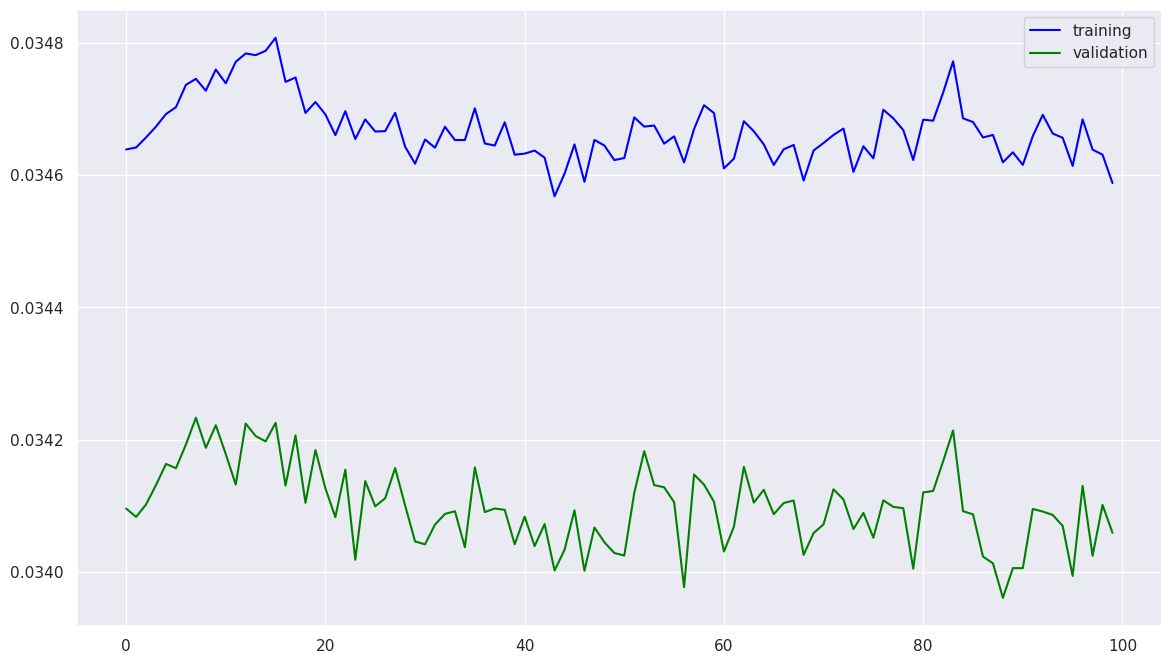

In [ ]:
smoothed = torch.Tensor(tlosses).view(-1, 50).mean(dim=1)
plt.plot(smoothed, label="training", color="blue")
smoothed = torch.Tensor(vlosses).view(-1, 50).mean(dim=1)
plt.plot(smoothed, label="validation", color="green")
plt.legend()

